<table>
<tr>                                                                                   
     <th>
         <div style='padding:15px;color:#030aa7;font-size:240%;text-align: center;font-style: italic;font-weight: bold;font-family: Georgia, serif'><a href="https://www.kaggle.com/datasets/uciml/mushroom-classification">Courbe ROC (Receiver Operating Characteristic)</a></div>
     </table>

# <b><div style='padding:15px;background-color:#d8dcd6;color:#030aa7;font-size:120%;text-align: left'>Introduction</div></b>
## <b><div style='padding:15px;background-color:#d8dcd6;color:#030aa7;font-size:120%;text-align: left'>Import libriries </div></b>

In [1]:
import pandas as pd, numpy as np, seaborn as sns, warnings, os, sys, time, copy as cp, pickle,re
from datetime import datetime as dt
from matplotlib import pyplot as plt

import matplotlib.font_manager as fm
import matplotlib.patheffects as path_effects

import plotly.express as px
import plotly.graph_objects as go

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics  import make_scorer, confusion_matrix, roc_curve, auc, accuracy_score, log_loss, hamming_loss, \
                             precision_score, recall_score, f1_score, fbeta_score, jaccard_score,  \
                             precision_recall_curve, average_precision_score, precision_recall_fscore_support, matthews_corrcoef

# <b><div style='padding:15px;background-color:#d8dcd6;color:#030aa7;font-size:120%;text-align: left'>Outils projet</div></b>

In [3]:
sys.path.append(os.path.abspath('../../outils/'))
from prjFormation import palette

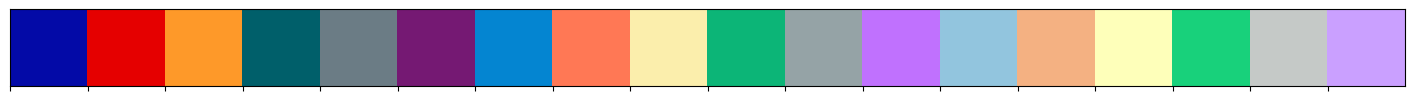

In [4]:
# palette = [ "#030aa7", "#e50000", "#d8863b", "#005f6a", "#6b7c85", "#751973", 
#             "#0485d1", "#ff7855", "#fbeeac", "#0cb577", "#95a3a6", "#c071fe", 
#             "#d1e5f0", "#fddbc7", "#ffffcb", "#12e193", "#d8dcd6", "#dfc5fe", 
#           ]
sns.palplot(sns.color_palette(palette[:18]))

In [5]:
from prjFormation import initProjet,affichageDonnees2d,affichageDonnees3d,createLinkageMatrix, afficheDendrogram, affichageDistribution,afficheColonneCible, add_median_labels, formatPct

In [6]:
from classificationBinaires import initDictionnaireClassificateurs, executionEssaiComparaisonClassificateurs,\
                                   affichageEvolutionMetriques, affichageROC, executeValidationCroisee,afficheSeparationsBinaires

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier

In [8]:
font1 = fm.FontProperties(size=20)
font2 = fm.FontProperties(size=24)

warnings.filterwarnings(action="ignore")
sns.set_style('darkgrid')
sns.set(font_scale=2)

In [9]:
projet = initProjet(repertoireRacine='.',nomProjet='Courbe ROC pour les penguins')

In [10]:
donnees = pd.read_csv('../../donnees/penguins_size.csv')
#donnees.Species = donnees.Species.apply(lambda x : x.replace('Iris-',''))
#donnees.columns = [colonne.replace('Cm','') if colonne != 'sex' else colonne for colonne in donnees.columns]
#donnees.set_index('Id',inplace=True)

donnees.dropna(inplace=True)
donnees = donnees[donnees.sex != '.']
donnees = donnees.drop(columns=['island'])
sex_dummies = pd.get_dummies(donnees['sex'], prefix='sex')
donnees = pd.concat([donnees, sex_dummies], axis=1)
donnees.drop(columns=['sex'], inplace=True)          


cible='species'

dict_species = {nom:i for i, nom in enumerate(donnees.species.sort_values().unique())}
dictR_species = {i:nom for i, nom in enumerate(donnees.species.sort_values().unique())}
donnees.sample(5)

,species,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex_FEMALE,sex_MALE
276,Gentoo,43.8,13.9,208.0,4300.0,True,False
202,Chinstrap,48.1,16.4,199.0,3325.0,True,False
119,Adelie,41.1,18.6,189.0,3325.0,False,True
136,Adelie,35.6,17.5,191.0,3175.0,True,False
314,Gentoo,44.5,14.7,214.0,4850.0,True,False


In [11]:
X = donnees.drop(columns=cible).copy()
y = donnees[cible].apply(lambda x: dict_species[x])
y.index = X.index
dict_species

{'Adelie': 0, 'Chinstrap': 1, 'Gentoo': 2}

In [12]:
X_train, X_test, y_train, y_test = train_test_split( X, 
                                                     y, 
                                                     test_size=0.4, 
                                                     random_state=0, 
                                                     stratify = y
                                                   ) 

In [13]:
nbClasses   = len(y_train.sort_values().unique())
listClasses = y_train.sort_values().unique()
    
y_trainA = label_binarize(y_train, classes=listClasses)
y_testA  = label_binarize(y_test, classes=listClasses)

# <b><div style='padding:15px;background-color:#d8dcd6;color:#030aa7;font-size:120%;text-align: left'>Separation des données pour l'apprentissage</div></b>

<img src="https://raw.githubusercontent.com/rbizoi/MachineLearning/refs/heads/master/images/classification/echantillonApprentissageTest.png" width="800">

# <b><div style='padding:15px;background-color:#d8dcd6;color:#030aa7;font-size:120%;text-align: left'>Déclaration du classificateur</div></b>

In [14]:
classificateur = OneVsRestClassifier(LogisticRegression(
                C=0.81113,
                max_iter=800,
                penalty='l2',
                solver='lbfgs',
                n_jobs=-1
            ))



classificateur.fit(X_train, y_trainA)


OneVsRestClassifier(estimator=LogisticRegression(C=0.81113, max_iter=800,
                                                 n_jobs=-1))

In [15]:
y_score     = classificateur.predict_proba(X_test)
y_pred      = classificateur.predict(X_test)

# <b><div style='padding:15px;background-color:#d8dcd6;color:#030aa7;font-size:120%;text-align: left'>Courbe ROC (Receiver Operating Caracteristic)</div></b>

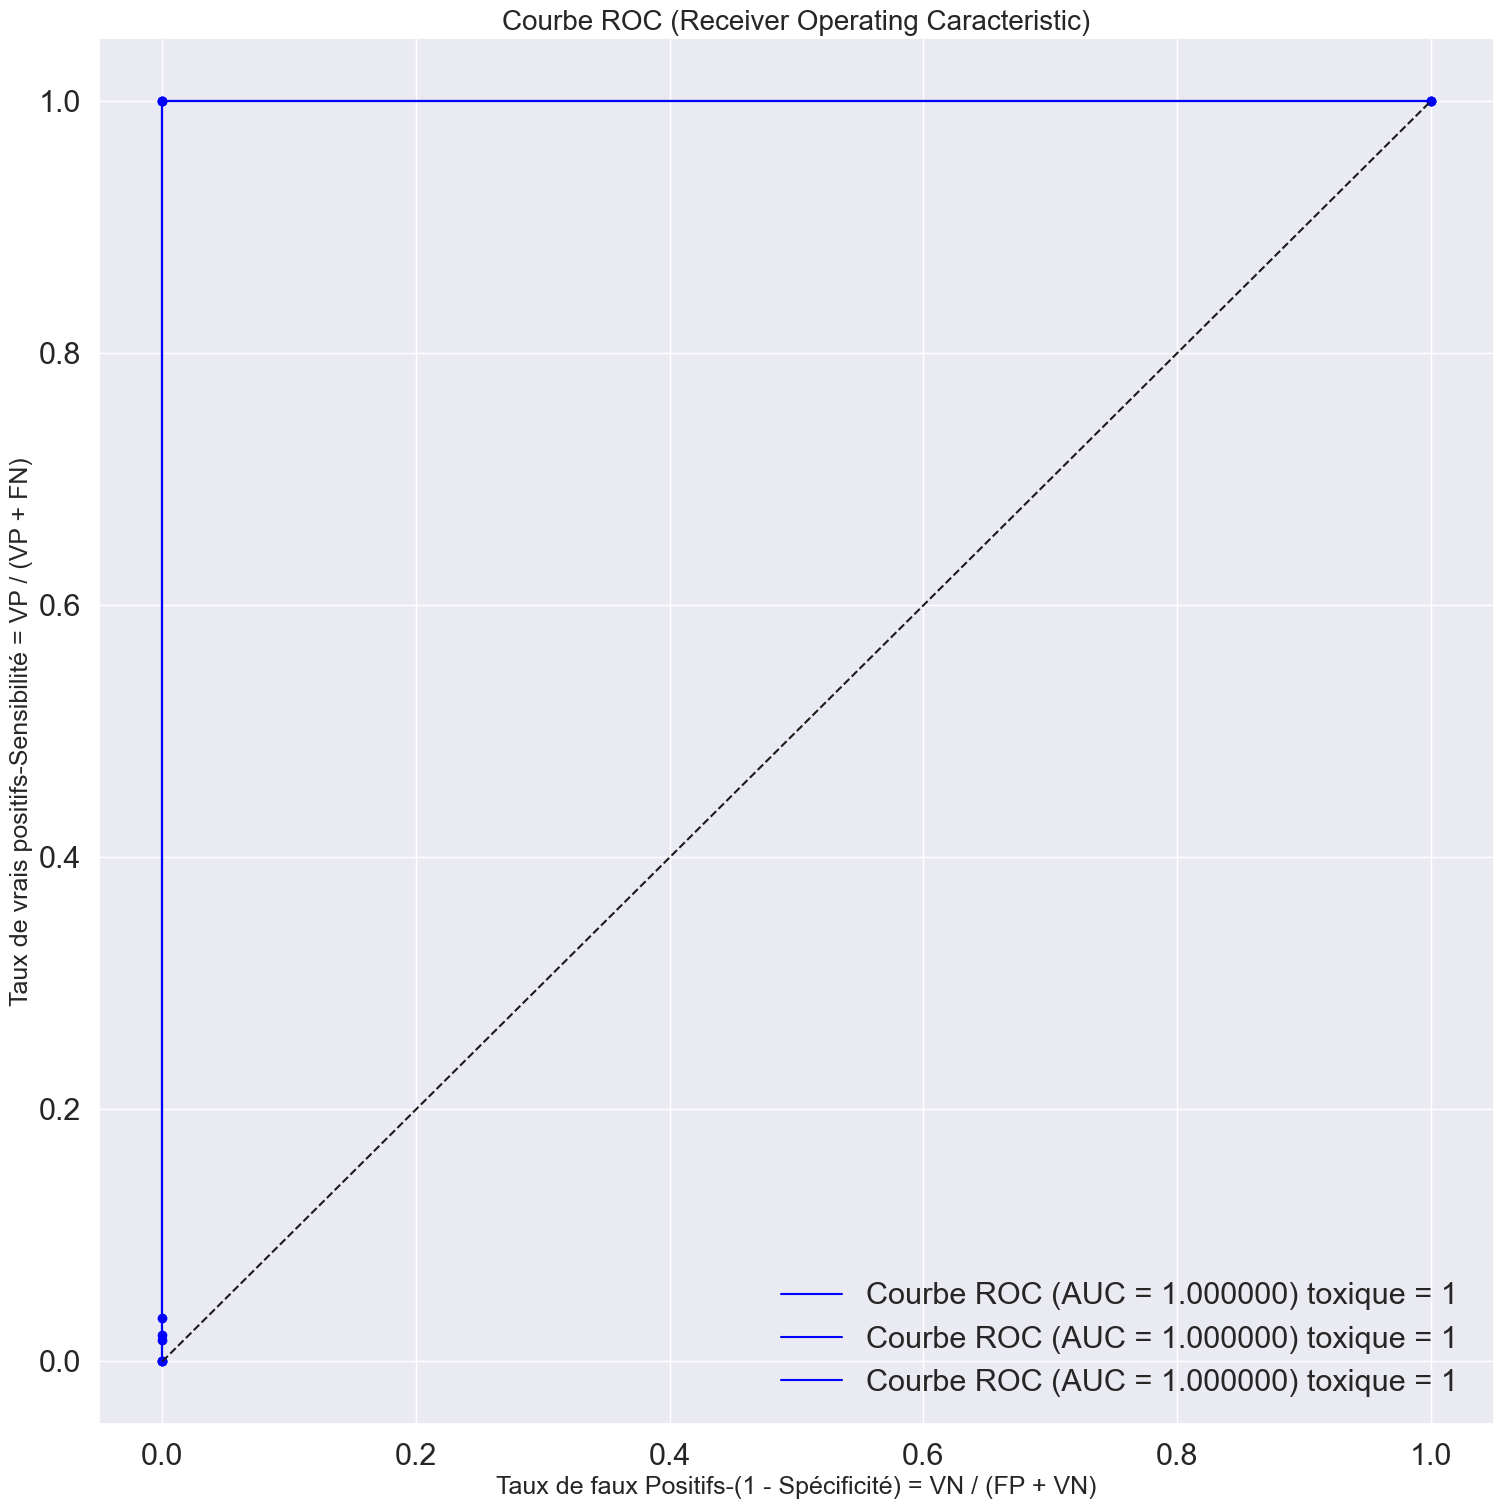

In [16]:

plt.figure(figsize=(18, 18))

for i in range(3):
    fauxPositifs, vraisPositifs, seuils = roc_curve(y_pred[:, i], y_score[:, i])
    roc_auc = auc(fauxPositifs, vraisPositifs)
    plt.scatter(fauxPositifs, vraisPositifs, color='blue')
    plt.plot( fauxPositifs, vraisPositifs, label=f'Courbe ROC (AUC = {roc_auc:0.6f}) toxique = 1 ', color='blue')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('Taux de faux Positifs-(1 - Spécificité) = VN / (FP + VN)',size=18)
plt.ylabel('Taux de vrais positifs-Sensibilité = VP / (VP + FN)',size=18)
plt.title('Courbe ROC (Receiver Operating Caracteristic)',size=20)
plt.legend(loc="lower right")
